In [24]:
import pandas as pd

# Load a battery file (replace with your actual file path)
file_path = "battery_alt_dataset/regular_alt_batteries/battery00.csv"  # Adjust as needed
df = pd.read_csv(file_path)

# Basic inspection
print("=== First 5 Rows ===")
print(df.head(), "\n")

print("=== Column Names ===")
print(df.columns.tolist(), "\n")

print("=== Missing Values ===")
print(df.isnull().sum(), "\n")

print("=== Unique 'mode' Values ===")
print(df['mode'].value_counts(), "\n")

=== First 5 Rows ===
            start_time   time  mode  voltage_charger  temperature_battery  \
0  2022-07-19 11:10:00  0.000   0.0            0.000                0.000   
1  2022-07-19 11:10:00  1.894   0.0            8.341               23.059   
2  2022-07-19 11:10:00  2.814   0.0            8.340               23.059   
3  2022-07-19 11:10:00  3.734   0.0            8.341               23.063   
4  2022-07-19 11:10:00  4.654   0.0            8.341               23.063   

   voltage_load  current_load  temperature_mosfet  temperature_resistor  \
0           NaN           NaN                 NaN                   NaN   
1           NaN           NaN                 NaN                   NaN   
2           NaN           NaN                 NaN                   NaN   
3           NaN           NaN                 NaN                   NaN   
4           NaN           NaN                 NaN                   NaN   

   mission_type  
0           NaN  
1           NaN  
2          

In [25]:
# Assign cycle numbers based on mode transitions
df['cycle_number'] = (df['mode'].diff() == -1).cumsum()

# Filter discharge cycles only
discharge_df = df[df['mode'] == -1]

# Check cycle distribution
print("=== Cycle Counts ===")
print("Total cycles:", discharge_df['cycle_number'].nunique())
print("\n=== First 5 Discharge Rows ===")
print(discharge_df.head(), "\n")

=== Cycle Counts ===
Total cycles: 175

=== First 5 Discharge Rows ===
              start_time     time  mode  voltage_charger  temperature_battery  \
324  2022-07-19 11:10:00  300.523  -1.0            8.340               22.963   
325  2022-07-19 11:10:00  301.463  -1.0            8.041               23.155   
326  2022-07-19 11:10:00  302.404  -1.0            8.030               23.170   
327  2022-07-19 11:10:00  303.345  -1.0            8.023               23.186   
328  2022-07-19 11:10:00  304.288  -1.0            8.016               23.201   

     voltage_load  current_load  temperature_mosfet  temperature_resistor  \
324        -0.026         0.152               22.64                 23.20   
325         8.329         2.523               22.65                 23.21   
326         8.320         2.521               22.66                 23.20   
327         8.312         2.523               22.68                 23.21   
328         8.305         2.521               22.71      

In [26]:
import matplotlib.pyplot as plt

ref_discharges = discharge_df[discharge_df['mission_type'] == 0].copy()
ref_discharges['discharge_time'] = ref_discharges.groupby('cycle_number')['time'].diff().fillna(0)
capacity = ref_discharges.groupby('cycle_number')['discharge_time'].sum() * 2.5 / 3600  # 2.5A current

# Print capacity values
print("=== Capacity per Cycle ===")
print(capacity.head(10))  # First 10 cycles
print("\n=== Final Capacity ===")
print(capacity.tail(10))  # Last 10 cycles

# Degradation stats
initial_capacity = capacity.iloc[0]
final_capacity = capacity.iloc[-1]
degradation_pct = (initial_capacity - final_capacity) / initial_capacity * 100
print(f"\nInitial Capacity: {initial_capacity:.2f} Ah")
print(f"Final Capacity: {final_capacity:.2f} Ah")
print(f"Degradation: {degradation_pct:.1f}%")

=== Capacity per Cycle ===
cycle_number
1      2.432800
41     2.329573
86     2.276002
130    2.220595
179    2.164424
221    2.114106
263    2.069008
308    2.026645
353    1.983619
Name: discharge_time, dtype: float64

=== Final Capacity ===
cycle_number
1      2.432800
41     2.329573
86     2.276002
130    2.220595
179    2.164424
221    2.114106
263    2.069008
308    2.026645
353    1.983619
Name: discharge_time, dtype: float64

Initial Capacity: 2.43 Ah
Final Capacity: 1.98 Ah
Degradation: 18.5%


In [27]:
# Extract voltage data for early and late cycles
cycle_1 = discharge_df[discharge_df['cycle_number'] == 1]
cycle_353 = discharge_df[discharge_df['cycle_number'] == 353]

# Print voltage stats
print("=== Cycle 1 Voltage Summary ===")
print(f"Start Voltage: {cycle_1['voltage_load'].max():.2f} V")
print(f"End Voltage: {cycle_1['voltage_load'].min():.2f} V")
print(f"Voltage Drop: {cycle_1['voltage_load'].max() - cycle_1['voltage_load'].min():.2f} V\n")

print("=== Cycle 353 Voltage Summary ===")
print(f"Start Voltage: {cycle_353['voltage_load'].max():.2f} V")
print(f"End Voltage: {cycle_353['voltage_load'].min():.2f} V")
print(f"Voltage Drop: {cycle_353['voltage_load'].max() - cycle_353['voltage_load'].min():.2f} V")

=== Cycle 1 Voltage Summary ===
Start Voltage: 8.33 V
End Voltage: -0.03 V
Voltage Drop: 8.36 V

=== Cycle 353 Voltage Summary ===
Start Voltage: 8.24 V
End Voltage: -0.03 V
Voltage Drop: 8.27 V


In [28]:
# Clean voltage data: Remove negative values and outliers
discharge_df_clean = discharge_df[discharge_df['voltage_load'] > 5.0]  # 2S pack cutoff = 5.0V

# Recalculate voltage stats for Cycle 1 and 353
cycle_1_clean = discharge_df_clean[discharge_df_clean['cycle_number'] == 1]
cycle_353_clean = discharge_df_clean[discharge_df_clean['cycle_number'] == 353]

print("=== Cleaned Cycle 1 Voltage Summary ===")
print(f"Start Voltage: {cycle_1_clean['voltage_load'].max():.2f} V")
print(f"End Voltage: {cycle_1_clean['voltage_load'].min():.2f} V")
print(f"Voltage Drop: {cycle_1_clean['voltage_load'].max() - cycle_1_clean['voltage_load'].min():.2f} V\n")

print("=== Cleaned Cycle 353 Voltage Summary ===")
print(f"Start Voltage: {cycle_353_clean['voltage_load'].max():.2f} V")
print(f"End Voltage: {cycle_353_clean['voltage_load'].min():.2f} V")
print(f"Voltage Drop: {cycle_353_clean['voltage_load'].max() - cycle_353_clean['voltage_load'].min():.2f} V")

=== Cleaned Cycle 1 Voltage Summary ===
Start Voltage: 8.33 V
End Voltage: 5.01 V
Voltage Drop: 3.32 V

=== Cleaned Cycle 353 Voltage Summary ===
Start Voltage: 8.24 V
End Voltage: 5.01 V
Voltage Drop: 3.23 V


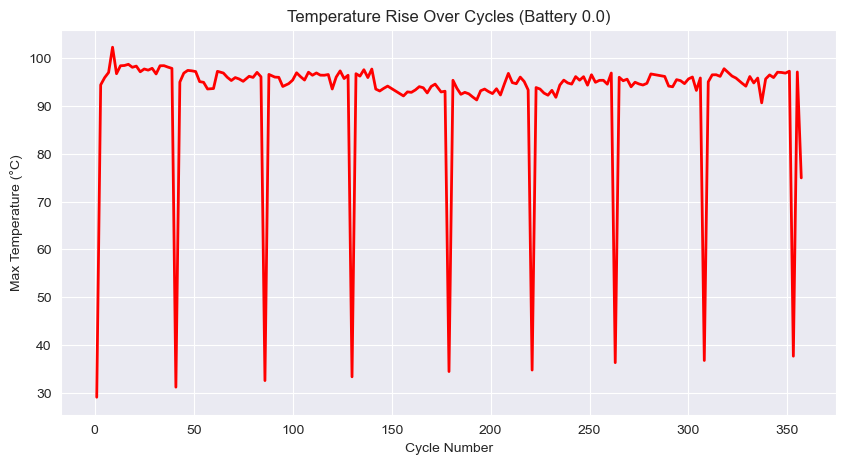

=== Temperature Stats ===
Cycle 1 Max Temp: 29.0°C
Cycle 353 Max Temp: 37.6°C


In [29]:
# Calculate max temperature per cycle
max_temp = discharge_df_clean.groupby('cycle_number')['temperature_battery'].max()

# Plot temperature rise vs. cycle number
plt.figure(figsize=(10, 5))
plt.plot(max_temp.index, max_temp.values, 'r-', linewidth=2)
plt.xlabel("Cycle Number")
plt.ylabel("Max Temperature (°C)")
plt.title("Temperature Rise Over Cycles (Battery 0.0)")
plt.grid(True)
plt.show()

# Print temperature stats
print("=== Temperature Stats ===")
print(f"Cycle 1 Max Temp: {max_temp.loc[1]:.1f}°C")
print(f"Cycle 353 Max Temp: {max_temp.loc[353]:.1f}°C")

In [30]:
# Get the list of cycles with reference discharges (from 'capacity' index)
reference_cycles = capacity.index.tolist()

# Filter max_temp and voltage data to these cycles
max_temp_aligned = max_temp.loc[reference_cycles]
start_voltage = discharge_df_clean[discharge_df_clean['cycle_number'].isin(reference_cycles)].groupby('cycle_number')['voltage_load'].max()
end_voltage = discharge_df_clean[discharge_df_clean['cycle_number'].isin(reference_cycles)].groupby('cycle_number')['voltage_load'].min()

# Create the report
report = pd.DataFrame({
    'Cycle': reference_cycles,
    'Capacity (Ah)': capacity.values,
    'Max Temperature (°C)': max_temp_aligned.values,
    'Start Voltage (V)': start_voltage.values,
    'End Voltage (V)': end_voltage.values
})

# Add SOH
report['SOH (%)'] = (report['Capacity (Ah)'] / 2.43) * 100

print("=== Battery 0.0 Degradation Report (Aligned) ===")
print(report)

=== Battery 0.0 Degradation Report (Aligned) ===
   Cycle  Capacity (Ah)  Max Temperature (°C)  Start Voltage (V)  \
0      1       2.432800                29.017              8.329   
1     41       2.329573                31.128              8.351   
2     86       2.276002                32.503              8.397   
3    130       2.220595                33.289              8.361   
4    179       2.164424                34.393              8.337   
5    221       2.114106                34.705              8.306   
6    263       2.069008                36.256              8.274   
7    308       2.026645                36.712              8.257   
8    353       1.983619                37.610              8.240   

   End Voltage (V)     SOH (%)  
0            5.009  100.115226  
1            5.005   95.867198  
2            5.012   93.662637  
3            5.001   91.382516  
4            5.006   89.070930  
5            5.001   87.000257  
6            5.008   85.144376  
7     

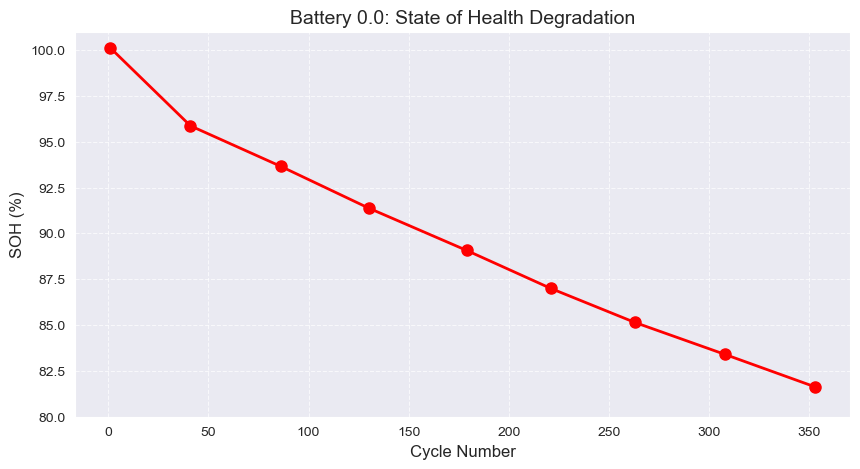

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(report['Cycle'], report['SOH (%)'], 'ro-', linewidth=2, markersize=8)
plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("SOH (%)", fontsize=12)
plt.title("Battery 0.0: State of Health Degradation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(80, 101)  # Emphasize degradation range
plt.show()

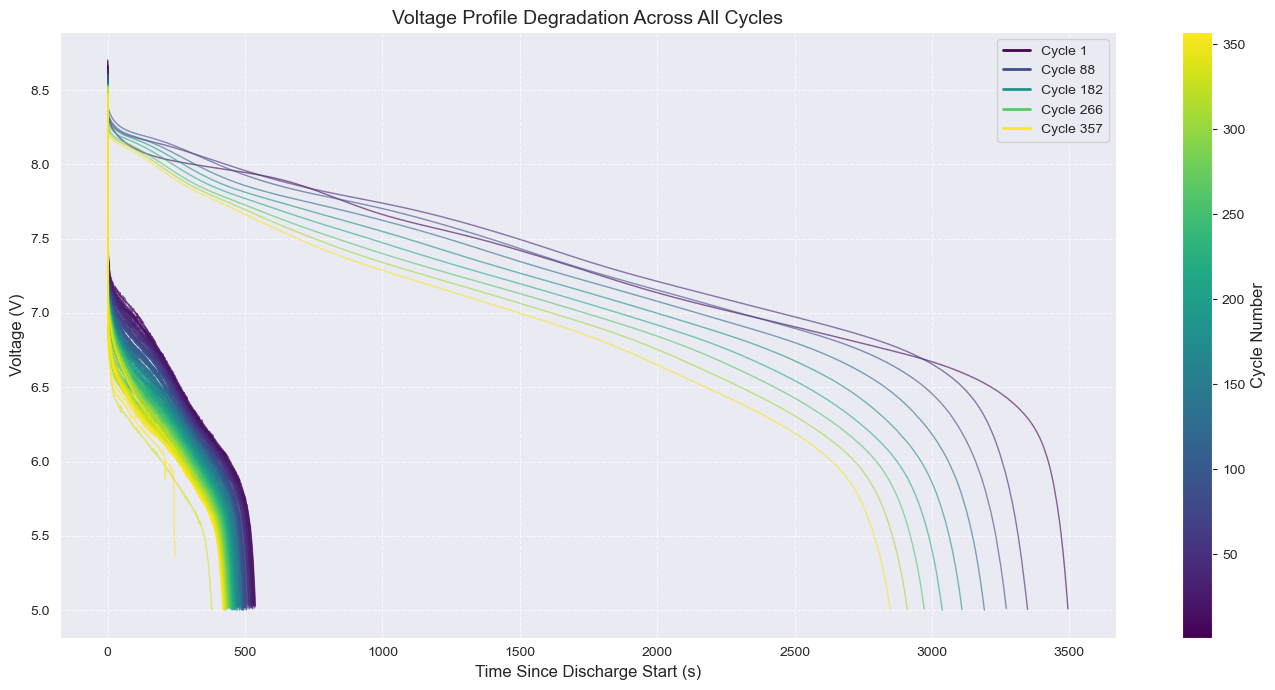

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Get all unique cycle numbers from the dataset
all_cycles = sorted(discharge_df_clean['cycle_number'].unique())

# Create a figure
fig, ax = plt.subplots(figsize=(14, 7))

# Create a colormap that maps from cycle number to color
norm = Normalize(vmin=min(all_cycles), vmax=max(all_cycles))
cmap = plt.cm.viridis

# Plot each cycle with a color based on its cycle number
for cycle in all_cycles:
    cycle_data = discharge_df_clean[discharge_df_clean['cycle_number'] == cycle].copy()
    cycle_data['relative_time'] = cycle_data['time'] - cycle_data['time'].min()

    # Get color for this cycle
    color = cmap(norm(cycle))

    # Plot with lower alpha to avoid overcrowding
    ax.plot(cycle_data['relative_time'],
            cycle_data['voltage_load'],
            color=color,
            alpha=0.6,
            linewidth=1.0)

# Add a few labeled cycles for the legend (otherwise legend would be too crowded)
legend_cycles = [min(all_cycles),
                 int(np.percentile(all_cycles, 25)),
                 int(np.percentile(all_cycles, 50)),
                 int(np.percentile(all_cycles, 75)),
                 max(all_cycles)]

for cycle in legend_cycles:
    ax.plot([], [],
            color=cmap(norm(cycle)),
            label=f'Cycle {cycle}',
            linewidth=2)

ax.set_xlabel("Time Since Discharge Start (s)", fontsize=12)
ax.set_ylabel("Voltage (V)", fontsize=12)
ax.set_title("Voltage Profile Degradation Across All Cycles", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='best')

# Create a scalar mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cycle Number', fontsize=12)

plt.tight_layout()
plt.show()

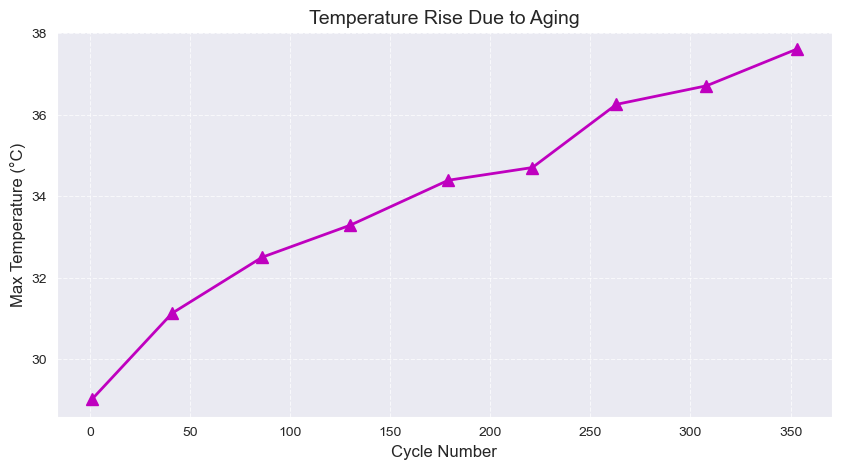

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(report['Cycle'], report['Max Temperature (°C)'], 'm^-', linewidth=2, markersize=8)
plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("Max Temperature (°C)", fontsize=12)
plt.title("Temperature Rise Due to Aging", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

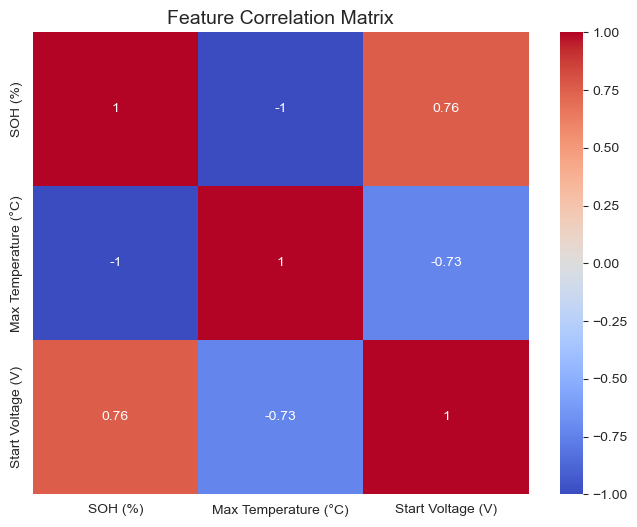

In [34]:
import seaborn as sns

corr = report[['SOH (%)', 'Max Temperature (°C)', 'Start Voltage (V)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.show()

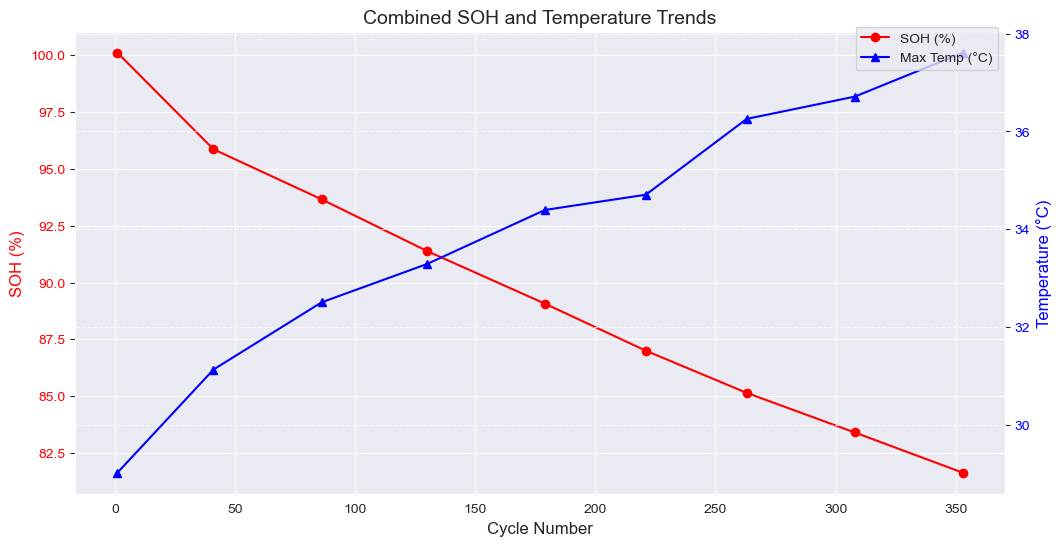

In [35]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# SOH and Temperature
ax1.plot(report['Cycle'], report['SOH (%)'], 'ro-', label='SOH (%)')
ax1.set_xlabel("Cycle Number", fontsize=12)
ax1.set_ylabel("SOH (%)", color='r', fontsize=12)
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(report['Cycle'], report['Max Temperature (°C)'], 'b^-', label='Max Temp (°C)')
ax2.set_ylabel("Temperature (°C)", color='b', fontsize=12)
ax2.tick_params(axis='y', labelcolor='b')

plt.title("Combined SOH and Temperature Trends", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [36]:
from IPython.display import display

# Format the report for readability
report_formatted = report.copy()
report_formatted['SOH (%)'] = report_formatted['SOH (%)'].round(2)
report_formatted['Max Temperature (°C)'] = report_formatted['Max Temperature (°C)'].round(1)
display(report_formatted.tail(10).style.hide(axis="index").set_caption("Key Degradation Metrics"))

Cycle,Capacity (Ah),Max Temperature (°C),Start Voltage (V),End Voltage (V),SOH (%)
1,2.432800,29.000000,8.329000,5.009000,100.120000
41,2.329573,31.100000,8.351000,5.005000,95.870000
86,2.276002,32.500000,8.397000,5.012000,93.660000
130,2.220595,33.300000,8.361000,5.001000,91.380000
179,2.164424,34.400000,8.337000,5.006000,89.070000
221,2.114106,34.700000,8.306000,5.001000,87.000000
263,2.069008,36.300000,8.274000,5.008000,85.140000
308,2.026645,36.700000,8.257000,5.004000,83.400000
353,1.983619,37.600000,8.240000,5.006000,81.630000
